<a href="https://colab.research.google.com/github/YaninaK/churn-prediction/blob/main/notebooks/02_Baseline_model_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока клиентов

## [EDA](https://github.com/YaninaK/churn-prediction/blob/main/notebooks/01_EDA.ipynb)

[Ссылка на данные](https://drive.google.com/file/d/1TAVECAfnel9lPfcpfel6qXhZSW2yNqdX/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy.stats import chi2_contingency, chisquare,  kstest

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = '/content/drive/MyDrive/ML_projects/06_Churn_prediction/'

## 1. Загрузка данных

In [4]:
df = pd.read_csv(PATH + 'data/01_raw/telco-customer-churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   20468 non-null  int64  
 1   annualincome                          20468 non-null  int64  
 2   calldroprate                          20468 non-null  float64
 3   callfailurerate                       20468 non-null  float64
 4   callingnum                            20468 non-null  int64  
 5   customerid                            20468 non-null  int64  
 6   customersuspended                     20468 non-null  object 
 7   education                             20468 non-null  object 
 8   gender                                20468 non-null  object 
 9   homeowner                             20468 non-null  object 
 10  maritalstatus                         20468 non-null  object 
 11  monthlybilledam

In [5]:
TARGET_NAME = 'churn'
ID = 'customerid'

## 2. Подготовка данных

### 2.1. Формирование датасета

In [6]:
def seq_padding(x, T=3):
  x = x.tolist()
  if len(x) < T:
    n = T - len(x)
    return x + n * [0]
  return x

vars_to_drop = [
    'totalcallduration', 'avgcallduration', 'noadditionallines', 'year', 'month',
]

def generate_dataset(df, vars_to_drop=vars_to_drop):
  features = [i for i in df.columns if not i in vars_to_drop]
  agg_const =  df[features].groupby(ID)[features].first()
  agg_add = df.groupby(ID).agg(
      no_info_1 = ('month', lambda x: 1 if x.min() > 1 else 0),
      no_info_3 = ('month', lambda x: 1 if x.max() < 3 else 0),
      seq_total_max = ('totalcallduration', 'max'),
      seq_total_min = ('totalcallduration', 'min'),
      seq_avg_max = ('avgcallduration', 'max'),
      seq_avg_min = ('avgcallduration', 'min'),
      seq_total_range = ('totalcallduration', lambda x: np.log(x.max()-x.min() + 1)),
      seq_avg_range = ('avgcallduration', lambda x: np.log(x.max()-x.min() + 1)),
      seq_total = ('totalcallduration', seq_padding),
      seq_avg = ('avgcallduration', seq_padding),
  )

  return pd.concat([agg_const, agg_add], axis=1)

In [7]:
df = generate_dataset(df)
df.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,no_info_1,no_info_3,seq_total_max,seq_total_min,seq_avg_max,seq_avg_min,seq_total_range,seq_avg_range,seq_total,seq_avg
customerid,,,,,,,,,,,,,,,,,,,,,
8827,58,97003,0.01,0.01,4251043995,8827,Yes,PhD or equivalent,Female,No,...,0,1,8683,8562,964,570,4.804021,5.978886,"[8683, 8562, 0]","[964, 570, 0]"
8853,75,47197,0.02,0.02,4251090145,8853,Yes,High School or below,Female,Yes,...,0,1,2956,1161,739,580,7.493317,5.075174,"[1161, 2956, 0]","[580, 739, 0]"


In [8]:
train, test = train_test_split(df, test_size=0.3, random_state=24, stratify=df[TARGET_NAME])
valid, test = train_test_split(test, test_size=0.5, random_state=24, stratify=test[TARGET_NAME])

train.shape,  valid.shape, test.shape

((6667, 34), (1429, 34), (1429, 34))

### 2.2. Подготовка временных последовательностей для модели LSTM

In [9]:
def seq_padding(x, T=3):
  x = x.tolist()
  if len(x) < T:
    n = T - len(x)
    return x + n * [0]
  return x
########################################

def preprocess_seq(df):
    seq = np.array(
          [df['seq_total'].tolist(), df['seq_avg'].tolist()]
      ).reshape(2, -1).T

    return seq


def fit_transform_seq(df):
  seq = preprocess_seq(df)

  scaler = StandardScaler()
  seq = scaler.fit_transform(seq)

  return scaler, seq.reshape(-1, 3, 2)


def transform_seq(df, scaler):
  seq = preprocess_seq(df)
  seq = scaler.transform(seq)

  return seq.reshape(-1, 3, 2)

In [10]:
scaler, seq_train = fit_transform_seq(train)
seq_valid = transform_seq(valid, scaler)
seq_test = transform_seq(test, scaler)

seq_train.shape, seq_valid.shape, seq_test.shape

((6667, 3, 2), (1429, 3, 2), (1429, 3, 2))

### 2.3. Кодирование бинарных категориальных признаков.

In [11]:
categorical_variables = train.dtypes[train.dtypes=='object'].index.tolist()[:-2]
categorical_variables = [
    i for i in categorical_variables if not i in ['state', 'education', 'occupation']
]
categorical_variables

['customersuspended',
 'gender',
 'homeowner',
 'maritalstatus',
 'usesinternetservice',
 'usesvoiceservice']

In [12]:
def map_categorical_features(df):
  X = df.copy()
  X['customersuspended'] = X['customersuspended'].map({'Yes': 1, 'No': 0})
  X['gender'] = X['gender'].map({'Male': 1, 'Female': 0})
  X['homeowner'] = X['homeowner'].map({'Yes': 1,'No': 0})
  X['maritalstatus'] = X['maritalstatus'].map({'Single': 1, 'Married': 0})
  X['usesinternetservice'] = X['usesinternetservice'].map({'Yes': 1, 'No': 0})
  X['usesvoiceservice'] = X['usesvoiceservice'].map({'Yes': 1, 'No': 0 })

  return X

In [13]:
train = map_categorical_features(train)
valid = map_categorical_features(valid)
test = map_categorical_features(test)

train[categorical_variables].sample(2)

,customersuspended,gender,homeowner,maritalstatus,usesinternetservice,usesvoiceservice
customerid,,,,,,
6326,1,0,0,0,0,0
6704,1,1,1,1,0,0


### 2.4. Численные переменные

In [14]:
selected_numeric_features = ['callfailurerate', 'numberofcomplaints', 'age', 'unpaidbalance']

In [15]:
scaler_num = StandardScaler()

train[selected_numeric_features] = scaler_num.fit_transform(train[selected_numeric_features])
valid[selected_numeric_features] = scaler_num.transform(valid[selected_numeric_features])
test[selected_numeric_features] = scaler_num.transform(test[selected_numeric_features])

## 3. Model

In [16]:
selected_features = selected_numeric_features + categorical_variables
selected_features

['callfailurerate',
 'numberofcomplaints',
 'age',
 'unpaidbalance',
 'customersuspended',
 'gender',
 'homeowner',
 'maritalstatus',
 'usesinternetservice',
 'usesvoiceservice']

In [17]:
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

vocab_s = train['state'].unique().tolist()
n_labels_s = len(vocab_s)
vocab_e = train['education'].unique().tolist()
vocab_o = train['occupation'].unique().tolist()
n_features_other = len(selected_features)

params = {
    'input_sequence_length': 3,
    'n_features': 2,
    'n_units': 8,
    'vocab_s': vocab_s,
    'n_labels_s': n_labels_s,
    'embedding_size_s': 4,
    'vocab_e': vocab_e,
    'vocab_o': vocab_o,
    'n_features_other': n_features_other,
    'n_units_others': 8,
    'n_units_all': 16,
}

In [18]:
def get_initial_bias_and_class_weight(train):
  pos = (train[TARGET_NAME]==1).sum()
  neg = (train[TARGET_NAME]==0).sum()

  initial_bias = np.log([pos/neg])
  print(f'initial_bias: {initial_bias}\n')

  total = train.shape[0]
  weight_for_0 = (1 / neg) * (total / 2.0)
  weight_for_1 = (1 / pos) * (total / 2.0)

  class_weight = {0: weight_for_0, 1: weight_for_1}
  print('Weight for class 0: {:.2f}'.format(weight_for_0))
  print('Weight for class 1: {:.2f}'.format(weight_for_1))

  return initial_bias, class_weight


def plot_loss(history):
  plt.semilogy(history.epoch, history.history['loss'], label='Train')
  plt.semilogy(
      history.epoch, history.history['val_loss'], label='Valid', linestyle="--"
  )
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("LSTM model Loss")
  plt.legend()

In [19]:
def get_model(
    input_sequence_length: int,
    n_features: int,
    n_units: int,
    vocab_s: list,
    n_labels_s: int,
    embedding_size_s: int,
    vocab_e: list,
    vocab_o: list,
    n_features_other: int,
    n_units_others: int,
    n_units_all: int,
    output_bias=None,
    metrics=METRICS,
):
  """
  # LSTM
  input_sequence_length=3
  n_features=2
  n_units=8

  # state
  vocab_s = train['state'].unique().tolist()
  n_labels_s = len(vocab_s)
  embedding_size_s = 4

  # education, occupation
  vocab_e = train['education'].unique().tolist()
  vocab_o = train['occupation'].unique().tolist()

  # other_features
  n_features_other = len(selected_features)
  n_units_others = 8

  n_units_all = 16

  """
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  # LSTM
  lstm_inputs = tf.keras.layers.Input(
      shape=(input_sequence_length, n_features), name="lstm_inputs"
  )
  lstm_output = tf.keras.layers.LSTM(n_units, name="lstm_output")(lstm_inputs)


  # states
  inputs_s = tf.keras.layers.Input(shape=(), name="state_inputs", dtype=tf.string)
  str_lookup_s = tf.keras.layers.StringLookup(
      vocabulary=vocab_s, name="string_lookup_state"
  )(inputs_s)
  embeddings_s = tf.keras.layers.Embedding(
      n_labels_s + 1,
      embedding_size_s,
      input_length=1,
      name="embeddings_state"
  )(str_lookup_s)
  flatten_s = tf.keras.layers.Flatten(name="flatten_state")(embeddings_s)

  # education, occupation
  inputs_e = tf.keras.layers.Input(shape=(), name="education_inputs", dtype=tf.string)
  str_lookup_layer_e = tf.keras.layers.StringLookup(
        vocabulary=vocab_e, output_mode="one_hot", name="str_lookup_layer_education"
  )(inputs_e)

  inputs_o = tf.keras.layers.Input(shape=(), name="occupation_inputs", dtype=tf.string)
  str_lookup_layer_o = tf.keras.layers.StringLookup(
        vocabulary=vocab_o, output_mode="one_hot", name="str_lookup_layer_occupation"
  )(inputs_o)

  # other_features
  inputs_all = tf.keras.layers.Input(
      shape=(n_features_other), name="inputs_all"
  )
  dense_others = tf.keras.layers.Dense(
      n_units_all, activation=tf.keras.activations.gelu, name="dense_others",
  )(inputs_all)

  # all
  concat_all = tf.keras.layers.Concatenate(axis=-1, name="concat_all")(
      [lstm_output, flatten_s, str_lookup_layer_e, str_lookup_layer_o, dense_others]
  )
  dense_all = tf.keras.layers.Dense(
      n_units_all, activation=tf.keras.activations.gelu, name="dense_all",
  )(concat_all)

  # output
  outputs = tf.keras.layers.Dense(
      1, activation=tf.keras.activations.sigmoid, name="outputs",
      bias_initializer=output_bias,
  )(concat_all)

  model = tf.keras.models.Model(
      [lstm_inputs, inputs_s, inputs_e, inputs_o, inputs_all],
      outputs,
      name="lstm_model"
  )
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=METRICS,
  )

  return model

In [20]:
model_path = "models/LSTM_emb_model_v1.keras"
history_path = "models/model_LSTM_emb_training_history_v1.joblib"

regenerate = True
if regenerate:
  initial_bias, class_weight = get_initial_bias_and_class_weight(train)
  lstm_model = get_model(**params, output_bias=initial_bias)
  n_epochs = 100
  batch_size = 64
  reduce_lr = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 3e-2 * 0.95 ** epoch
  )
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_prc',
      patience=20,
      min_delta=1e-06,
      verbose=1,
      mode="max",
      restore_best_weights=True,
  )

  history = lstm_model.fit(
      [
          seq_train,
          train['state'],
          train['education'],
          train['occupation'],
          train[selected_features]
      ],
      train[TARGET_NAME],
      epochs=n_epochs,
      validation_data=(
          [
              seq_valid,
              valid['state'],
              valid['education'],
              valid['occupation'],
              valid[selected_features]
          ],
          valid[TARGET_NAME]
      ),
      class_weight=class_weight,
      batch_size=batch_size,
      verbose=0,
      callbacks=[reduce_lr, early_stopping],
      shuffle=True,
      workers=-1,
      use_multiprocessing=True
  )
  lstm_model.save(PATH + model_path)
  joblib.dump(history, PATH + history_path)

else:
  lstm_model = tf.keras.models.load_model(PATH + model_path)
  history = joblib.load(PATH + history_path)

initial_bias: [-2.30820773]

Weight for class 0: 0.55
Weight for class 1: 5.53
Restoring model weights from the end of the best epoch: 7.
Epoch 27: early stopping


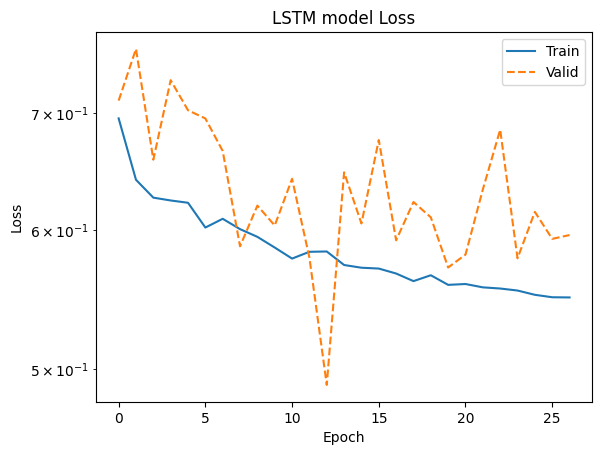

In [21]:
plot_loss(history)

In [22]:
results = lstm_model.evaluate(
    [
        seq_train,
        train['state'],
        train['education'],
        train['occupation'],
        train[selected_features]
    ],
    train[TARGET_NAME],
    batch_size=64,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6602


In [23]:
baseline_results = lstm_model.evaluate(
    [seq_test, test['state'], test['education'], test['occupation'], test[selected_features]],
    test[TARGET_NAME], batch_size=64, verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.6540639996528625
cross entropy :  0.6540639996528625
Brier score :  0.23988033831119537
tp :  109.0
fp :  623.0
tn :  677.0
fn :  20.0
accuracy :  0.5500349998474121
precision :  0.1489071100950241
recall :  0.8449612259864807
auc :  0.7142724990844727
prc :  0.16470231115818024

